In [1]:
!pip install qiskit-aqua
!pip install qiskit
!pip install qiskit_optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.7/198.7 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.2/640.2 KB 46.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.9/929.9 KB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import time
import math
import itertools

import networkx as nx
%matplotlib inline

from qiskit import Aer
from qiskit_optimization.applications import Maxcut
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer

### Brute force solution

In [4]:
def solve_brute_force(n_agents, induced_subgraph_game):
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]

  x = [int(t) for t in reversed(list(bin(0)[2:].zfill(n_agents)))]
  cost = [[w[i][j]*x[i]*(1-x[j]) for j in range(n_agents)] for i in range(n_agents)]
  best_cost_brute = sum([sum(i) for i in cost])
  xbest_brute = x

  for b in range(1, 2**(n_agents-1)):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n_agents)))]
    cost = [[w[i][j]*x[i]*(1-x[j]) for j in range(n_agents)] for i in range(n_agents)]
    cost = sum([sum(i) for i in cost])
    if cost > best_cost_brute:
      best_cost_brute = cost
      xbest_brute = x
  return np.array(xbest_brute), -best_cost_brute

### Qiskit exact solution using NumpyEigensolver (Cassical)

In [5]:
def solve_qiskit_classical_eigensolver(n_agents, induced_subgraph_game):
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]
  w = np.array([np.array(row) for row in w])
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  qubitOp, offset = qp.to_ising()
  exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
  result = exact.solve(qp)
  return result.x, -result.fval

### Qiskit heuristic solution using QAOA

In [6]:
def solve_qiskit_QAOA(n_agents, induced_subgraph_game, reps = 1, simulator = "aer_simulator_statevector", shots=1000, seed_simulator=123, seed_transpiler=123):
  backend=Aer.get_backend(simulator)
  qins = QuantumInstance(backend=backend, shots=shots, seed_simulator=seed_simulator, seed_transpiler=seed_transpiler)
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]
  w = np.array([np.array(row) for row in w])
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  qubitOp, offset = qp.to_ising()
  algorithm_globals.random_seed = seed
  heuristic = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=reps, quantum_instance=qins))
  result = heuristic.solve(qp)
  return result.x, -result.fval

### DWave solution using QAOA

In [7]:
def solve_dwave(n, induced_subgraph_game, save_log=False, name_folder='distribution', n_samples= 4000, n_run=5, seed=None):
    
    for run in np.arange(1,n_run+1):
        print('.',end='')
        linear, quadratic = get_linear_quadratic_coeffs(n, induced_subgraph_game)
        sample = dwave_solver(linear, quadratic, offset = 0.0, runs=n_samples)

        if save_log:
            if seed is not None:
                path = os.path.join('QA_results', str(seed), name_folder, str(n), 'run_'+str(run))
            else:
                path = os.path.join('QA_results', name_folder, str(n), 'run_'+str(run))
            create_dir(path)

            try:
                sample.to_pandas_dataframe().to_csv(os.path.join(path, 'solutions.csv'))
                save_json(os.path.join(path, 'log'), sample.info)
            except:
                print("\n **** Warning: results for",  name_folder, "with", n, "agents not saved*** \n")


        dwave_annealer_solution=[]
        for key, value in sample.first[0].items():
            dwave_annealer_solution.append(value)

        dwave_annealer_solution = np.array(dwave_annealer_solution)
        dwave_annealer_value = from_columns_to_string(sample.to_pandas_dataframe()).loc[0,'energy']

        dwave_annealer_tte = sample.info['timing']['qpu_sampling_time']/10**6
    
    return dwave_annealer_solution, dwave_annealer_value, dwave_annealer_tte

### Get Linear and Quadratic coefficients

In [8]:
def get_linear_quadratic_coeffs(n_agents, induced_subgraph_game):
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]
  w = np.array([np.array(row) for row in w])
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
  quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)
  linear = {'x_'+str(idx):-round(value,2) for idx,value in enumerate(linear[0])}
  quadratic = {('x_'+str(iy),'x_'+str(ix)):-quadratic[iy, ix] for iy, ix in np.ndindex(quadratic.shape) if iy<ix}
  return linear, quadratic

### Get QUBO matrix

In [9]:
def get_qubo_matrix(linear, quadratic):
  Q = np.zeros([len(linear),len(linear)])
  #diagonal elements
  for key,value in linear.items():
    Q[int(key.split('_')[1]),int(key.split('_')[1])] = value
  #non diagonal elements
  for key,value in quadratic.items():
    Q[int(key[0].split('_')[1]),int(key[1].split('_')[1])] = value
    Q[int(key[1].split('_')[1]),int(key[0].split('_')[1])] = value
  return Q

### Run experiments with different combinations of distributions and problem sizes

For comparitive analysis of Brute force, Eigensolver and QAOA solutions

In [10]:
import qiskit
qiskit.utils.algorithm_globals.massive=True

In [11]:
def normal(size=1, mu=0, sigma=5, low=-10, high=10):
    values = np.random.normal(mu, sigma, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values

def uniform(size=1, low=-5, high=5):
    values = np.random.normal(low, high, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values

def laplace(size=1, loc=0, scale=5, low=-10, high=10):
    values = np.random.laplace(loc, scale, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values


def generate_induced_subgraph_game(distribution, n_agents, **kwargs):
    induced_subgraph_game = {}
    keys = list(itertools.combinations(range(1,n_agents+1), 2))
    totalinteractions = len(keys)
    values = distribution(totalinteractions, **kwargs)
    for i,key in enumerate(keys):
        induced_subgraph_game[','.join(map(str,key))] = round(values[i],2)
    return induced_subgraph_game

In [14]:
from datetime import datetime
timestamp = datetime.now().strftime("%m%d%Y%H%M%S")

simulator = 'aer_simulator'

table_contents = []

distributions = [
    #normal,
    laplace
]

n_agents = np.arange(18,19).tolist()

seed = 123

# If 'True', checks QAOA for p>1 also
QAOA_p_increment_flag = False

report_filename = '/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/split_report_' +  str(seed) + '_' + simulator + '.txt'

In [15]:
for distribution in distributions:
  print(f'Executing {distribution.__name__} distribution:',end='\n')
  for n in n_agents:
    print(f'n = {n} |',end=' ')
    np.random.seed(seed=seed)
    induced_subgraph_game = generate_induced_subgraph_game(distribution,n)

    start_time = time.time()
    #print(" - Running Brute Force", end="")
    bruteforce_solution, bruteforce_value = solve_brute_force(n, induced_subgraph_game) # np.repeat(0,n), 0.0
    bruteforce_tte = (time.time() - start_time)
    #print(' (', time.strftime('%H:%M:%S', time.gmtime(bruteforce_tte)), ')', end = "")

    start_time = time.time()
    qiskit_eigensolver_solution, qiskit_eigensolver_value = solve_qiskit_classical_eigensolver(n, induced_subgraph_game) # np.repeat(0,n), 0.0
    qiskit_eigensolver_tte = (time.time() - start_time)
    qiskit_eigensolver_correctness = ((bruteforce_solution==qiskit_eigensolver_solution).all() or (bruteforce_solution==(1-qiskit_eigensolver_solution)).all())

    reps = 0
    qiskit_qaoa_correctness = False
    while(not qiskit_qaoa_correctness and (QAOA_p_increment_flag or not reps)):
      reps = reps+1
      start_time = time.time()
      print('p (QAOA reps) =',reps)
      qiskit_qaoa_solution, qiskit_qaoa_value = solve_qiskit_QAOA(n, induced_subgraph_game, reps, simulator = simulator)  # np.repeat(0,n), 0.0
      qiskit_qaoa_tte = (time.time() - start_time)
      qiskit_qaoa_correctness = ((bruteforce_solution==qiskit_qaoa_solution).all() or (bruteforce_solution==(1-qiskit_qaoa_solution)).all())
      row = []
      row.append(distribution.__name__)
      row.append(n)
      row.append(''.join(map(str,map(int,bruteforce_solution))))
      row.append(bruteforce_value)
      row.append(bruteforce_tte)
      row.append(''.join(map(str,map(int,qiskit_eigensolver_solution))))
      row.append(qiskit_eigensolver_value)
      row.append(qiskit_eigensolver_tte)
      row.append(qiskit_eigensolver_correctness)
      row.append(''.join(map(str,map(int,qiskit_qaoa_solution))))
      row.append(qiskit_qaoa_value)
      row.append(qiskit_qaoa_tte)
      row.append(reps)
      row.append(qiskit_qaoa_correctness)
      report_file_obj = open(report_filename,'a+')
      report_file_obj.write('__'.join(map(str,row))+'\n')
      report_file_obj.close()
      table_contents.append(row)
  print('\n')

Executing laplace distribution:
n = 18 | p (QAOA reps) = 1




## Display results from generated report file

In [23]:
report_filename = '/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/split_report_' +  str(seed) + '_' + simulator + '.txt'
report_filename

'/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/split_report_123_aer_simulator.txt'

In [24]:
report_file_obj = open(report_filename,'r')
table_contents = [line.split('__') for line in report_file_obj.readlines()]

In [25]:
#view output table
def highlight_false(s, column):
    is_false = pd.Series(data=False, index=s.index)
    is_false[column] = s.loc[column].strip() == 'False'
    return ['color: #A16060' if is_false.any() else '' for v in is_false]

column_arrays = [['Distribution', 'No. of Agents', 'Brute Force Solution','Brute Force Solution','Brute Force Solution', \
                  'Qiskit Eigensolver','Qiskit Eigensolver','Qiskit Eigensolver','Qiskit Eigensolver', 'Qiskit QAOA','Qiskit QAOA',\
                  'Qiskit QAOA', 'Qiskit QAOA', 'Qiskit QAOA'], 
                 ['', '', 'Result', 'Value', 'TTE', 'Result', 'Value', 'TTE', 'Correctness', 'Result', 'Value', 'TTE', 'reps (p)', 'Correctness']]

#df = pd.DataFrame(table_contents, columns=table_headers)
df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))

df.apply(pd.to_numeric, errors='ignore')

for col in df.columns:
  try:
    if 'No. of Agents' in col or 'reps (p)' in col:
      df[col] = df[col].astype(int)
    elif 'Result' in col:
      raise
    else:
      df[col] = df[col].astype(float)
  except:
    continue

df.sort_values(['Distribution','No. of Agents', ('Qiskit QAOA', 'reps (p)')], ascending=[True, True, True], inplace=True)

df = df.round(decimals = 2)

s = df.style.apply(highlight_false, column=('Qiskit QAOA', 'Correctness'), axis=1)
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', 'grey')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #1D1D1D; color: white;'
}
s.set_table_styles([cell_hover, index_names, headers])

tte_col_bgcolor = '154360'
value_col_bgcolor = '784212'
resullt_col_bgcolor = '186A3B'
correctness_col_bgcolor = '693f3f'


s.set_table_styles({
    ('No. of Agents', ''): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white'}],
    ('Brute Force Solution', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Brute Force Solution', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Brute Force Solution', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Qiskit Eigensolver', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Qiskit Eigensolver', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Qiskit Eigensolver', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Qiskit Eigensolver', 'Correctness'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+correctness_col_bgcolor}],
    ('Qiskit QAOA', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Qiskit QAOA', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Qiskit QAOA', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Qiskit QAOA', 'reps (p)'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black'}],
    ('Qiskit QAOA', 'Correctness'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+correctness_col_bgcolor}],
    ('Dwave Annealer', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Dwave Annealer', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Dwave Annealer', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Dwave Annealer', 'Correctness'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+correctness_col_bgcolor}]
}, overwrite=False, axis=0)

In [26]:
df[df[('Qiskit QAOA', 'reps (p)')]==1]
#df[('Qiskit QAOA', 'reps (p)')]

Distribution No. of Agents Brute Force Solution                 \
                                             Result   Value    TTE   
153      laplace             2                   00   -0.00   0.00   
154      laplace             3                  110   -6.74   0.00   
155      laplace             4                 1000   -4.24   0.00   
156      laplace             5                00110   -6.09   0.00   
157      laplace             6               010110  -16.80   0.00   
159      laplace             7              0111100  -28.19   0.00   
160      laplace             8             01100010  -22.13   0.01   
161      laplace             9            100111010  -31.14   0.02   
162      laplace            10           0001101000  -42.57   0.04   
163      laplace            11          00111110110  -44.44   0.10   
164      laplace            12         100011011110  -48.25   0.24   
168      laplace            13        0011101001110  -62.79   0.52   
254      laplace            14       01011010101010  -79.18   1.22   
171      laplace            15      110101010000100  -95.17   2.71   
175      laplace            16     0111001001010100 -100.88   6.27   
209      laplace            17    11001101110001000 -108.53  13.82   
255      laplace            18   110111010000000110 -123.96  32.13   
5         normal             2                   10   -5.43   0.00   
6         normal             3                  010   -4.02   0.00   
7         normal             4                 0100  -15.85   0.00   
8         normal             5                01010  -25.51   0.00   
9         normal             6               000110  -33.52   0.00   
10        normal             7              0100100  -22.71   0.00   
11        normal             8             10101010  -32.98   0.01   
12        normal             9            111111100  -50.24   0.02   
0         normal            10           1011001000  -66.82   0.04   
1         normal            11          10110100000  -68.55   0.09   
2         normal            12         101110000000  -55.28   0.23   
13        normal            13        1011010010000  -82.56   0.99   
31        normal            14       01001111111000  -97.06   1.22   
32        normal            15      101000100110000 -104.86   2.75   
52        normal            16     0101111110101010 -130.28   6.49   
72        normal            17    10100000011001000 -116.11  13.84   
112       normal            18   010111111010111100 -123.34  32.03   

     Qiskit Eigensolver                                    Qiskit QAOA  \
                 Result   Value    TTE Correctness              Result   
153                  00   -0.00   0.05        True                  00   
154                 110   -6.74   0.02        True                 110   
155                1000   -4.24   0.03        True                1000   
156               11001   -6.09   0.03        True               00110   
157              010110  -16.80   0.04        True              110110   
159             0111100  -28.19   0.05        True             1000011   
160            01100010  -22.13   0.07        True            01100010   
161           011000101  -31.14   0.09        True           100111010   
162          1110010111  -42.57   0.16        True          1110010111   
163         00111110110  -44.44   0.20        True         00111110110   
164        011100100001  -48.25   0.30        True        011100100101   
168       0011101001110  -62.79   0.56        True       1100010110001   
254      01011010101010  -79.18   1.14        True      11100001011100   
171     001010101111011  -95.17   2.33        True     100111010010100   
175    1000110110101011 -100.88   5.04        True    1111001111010001   
209   00110010001110111 -108.53  11.11        True   11001101100011100   
255  110111010000000110 -123.96  24.08        True  101011010100110111   
5                    10   -5.43   0.04        True                  10   
6  

In [27]:
df = df[df[('Qiskit QAOA', 'reps (p)')]==1]
df = pd.concat([df['Distribution'], df['No. of Agents'], df['Brute Force Solution']['TTE'], df['Qiskit Eigensolver']['TTE'], df['Qiskit QAOA']['TTE']], axis = 1)#,    'TTE']
df.columns=['Distribution', 'No. of Agents', 'TTE(BF)', 'TTE(QUBO)', 'TTE(QAOA)']
df.head()

,Distribution,No. of Agents,TTE(BF),TTE(QUBO),TTE(QAOA)
153,laplace,2,0.0,0.05,1.22
154,laplace,3,0.0,0.02,0.11
155,laplace,4,0.0,0.03,0.17
156,laplace,5,0.0,0.03,0.20
157,laplace,6,0.0,0.04,0.47


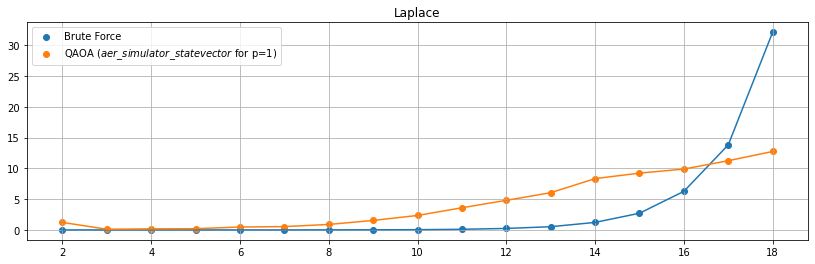

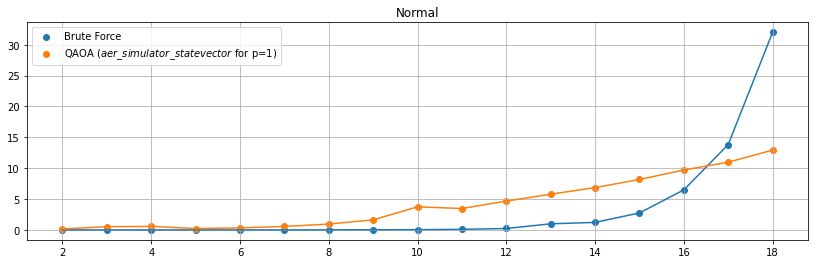

In [29]:
import matplotlib.pyplot as plt


folder = 'output-optimal-split'
#create_dir(folder)
for distr in df.Distribution.unique():
    data = df.loc[df.Distribution == distr, ]
    plt.figure(figsize=(14,4))

    plt.plot(data['No. of Agents'], data['TTE(BF)'].astype(float).to_numpy())  
    plt.scatter(data['No. of Agents'], data['TTE(BF)'].astype(float).to_numpy(), label='Brute Force')

    plt.plot(data['No. of Agents'], data['TTE(QAOA)'].astype(float).to_numpy())
    plt.scatter(data['No. of Agents'], data['TTE(QAOA)'].astype(float).to_numpy(), label='QAOA ($aer\_simulator\_statevector$ for p=1)')

    # plt.plot(data['No. of Agents'], np.log2(data['TTE(BF)'].astype(float).to_numpy()+10**(-5))  )
    # plt.scatter(data['No. of Agents'], np.log2(data['TTE(BF)'].astype(float).to_numpy()+10**(-5)), label='Brute Force')
    # # plt.plot(data['No. of Agents'], data['TTE(QUBO)'].astype(float))
    # # plt.scatter(data['No. of Agents'], data['TTE(QUBO)'].astype(float), label='Classical QUBO')
    # plt.plot(data['No. of Agents'], np.log10(data['TTE(QA)'].astype(float).to_numpy()))
    # plt.scatter(data['No. of Agents'], np.log10(data['TTE(QA)'].astype(float).to_numpy()), label='Quantum Annealing')
    
    plt.title(distr.title())
    plt.legend()
    plt.autoscale(enable=True)
    plt.grid()
    plt.savefig(distr+ '_aer_simulator_statevector.jpeg')
    plt.show()